# GET POSSIBLE FISH FROM SEGMENTED WELL

In [95]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import skimage
import cv2 as cv

from skimage import filters, measure, io, segmentation, morphology
from src.well.find_well_props import find_well_props
from src.models import *

from skimage.exposure import equalize_hist
from skimage.morphology import *
from skimage.filters.thresholding import threshold_yen

## Find well props

# Searching well properties
_____________________________________________________________
# Hough-transformation for the well
_____________________________________________________________
# Creating mask for well
_____________________________________________________________
# Getting bounding box of well
_____________________________________________________________


Text(0.5, 1.0, 'Mask')

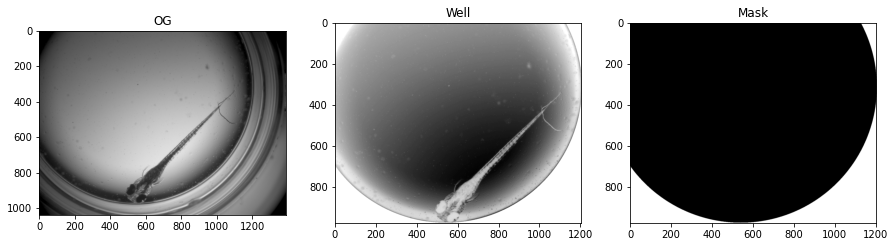

In [96]:
fishy = InputImage('zf1.jpg')

fishy = find_well_props(fishy)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 10))

ax[0].imshow(fishy.og, "binary")
ax[0].set_title('OG')

ax[1].imshow(fishy.processed, "binary")
ax[1].set_title('Well')

ax[2].imshow(fishy.well_props.mask.cropped, "binary")
ax[2].set_title('Mask')

# SOBEL EDGE DETECTION

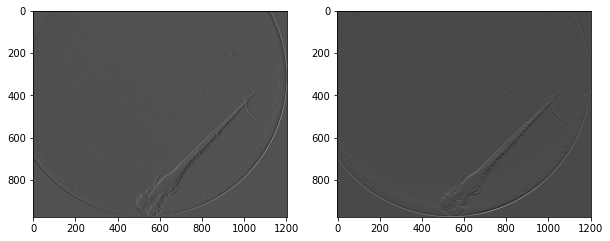

In [106]:
src = fishy.well_props.mask.cropped_masked
#gaussian = cv.GaussianBlur(src, ksize=(3, 3), sigmaX=3)


ddepth = cv.CV_16S
grad_x = cv.Sobel(src=src, ddepth=ddepth, dx=1, dy=0, ksize=3)
grad_y = cv.Sobel(src=src, ddepth=ddepth, dx=0, dy=1, ksize=3)

fig, ax = plt.subplots(1, 2, figsize=(10, 10))

ax[0].imshow(grad_x, 'binary')
ax[1].imshow(grad_y, 'binary')


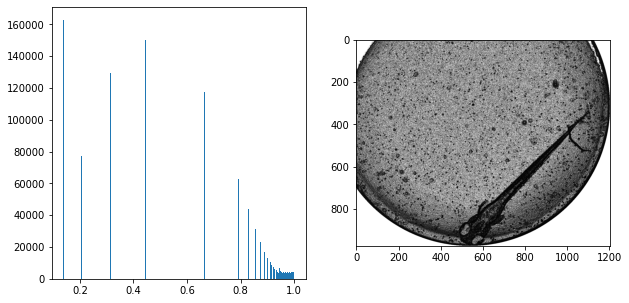

In [107]:
abs_grad_x = cv.convertScaleAbs(grad_x)
abs_grad_y = cv.convertScaleAbs(grad_y)

grad = cv.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0)

eq_grad = equalize_hist(grad)  # Equalizing values for better separation

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].hist(eq_grad.ravel(), 255)
ax[1].imshow(eq_grad, 'binary')

# Yen threshold

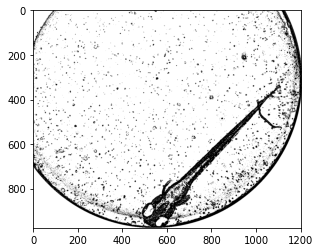

In [108]:
trsh = (eq_grad > threshold_yen(eq_grad))
plt.imshow(trsh, "binary")

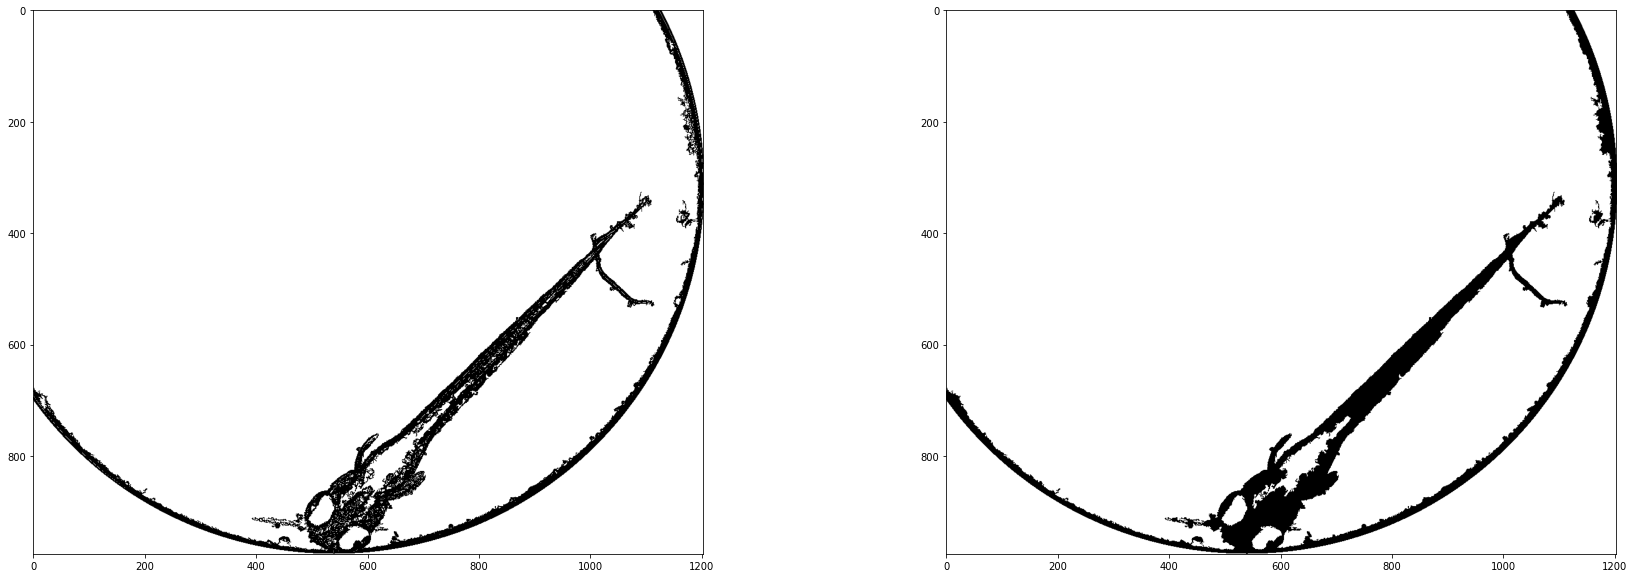

In [109]:
fig, ax = plt.subplots(1, 2, figsize=(30, 10))
size = fishy.well_props.mask.cropped_masked.size * 0.01

obj = remove_small_objects(trsh, size * 0.1)
hole = remove_small_holes(obj, size * 0.1)

hole = np.uint8(hole)

ax[0].imshow(obj, "binary")
ax[1].imshow(hole, "binary")

# Removing meniscus

In [110]:
def get_mean_col_sum_for_structuring_element(data: np.ndarray, corner: str,
                                             corrected_step: bool = False):  #cont, mod_cont
    thresh_well = np.zeros_like(data.shape)

    col_sum = np.sum(data[-1:1])  # in matlab ->   data'
    mean_data = np.floor(np.mean(col_sum[(col_sum > 0)]))
    """
        if not corrected_step:
            img = cont
        else:
            img = mod_cont
    """
    if not np.isnan(mean_data):
        structuring_element = disk(mean_data)
        if corner == 'lt':
            thresh_well = dilation(
                data[0:np.floor(data.shape[0] / 2), 0:np.floor(data.shape[1] / 2)],
                structuring_element)
        elif corner == 'lb':
            thresh_well = dilation(
                data[np.floor(data.shape[0] / 2):data.shape[0], 0:np.floor(data.shape[1] / 2)],
                structuring_element)
        elif corner == 'rt':
            thresh_well = dilation(
                data[0:np.floor(data.shape[0] / 2), np.floor(data.shape[1] / 2):data.shape[1]],
                structuring_element)
        elif corner == 'rb':
            thresh_well = dilation(
                data[np.floor(data.shape[0] / 2):data.shape[0],
                np.floor(data.shape[1] / 2):data.shape[1]],
                structuring_element)

    return thresh_well

In [115]:
def get_meniscus_(binary_img: np.ndarray, mask: np.ndarray, corrected=False) -> np.ndarray:
    if binary_img.shape != mask.shape:
        raise Exception("Arguments 'binary_img' and 'well_mask' must have equal shape" +
                        f"\n'binary_img': {binary_img.shape} != 'well_mask': {mask.shape}")

    possible_well_size_th = np.zeros_like(binary_img)
    remaining_binary_img = binary_img.copy()

    if not corrected:
        structuring_element = disk(25)
        eroded_well = erosion(mask, structuring_element)
        remaining_binary_img[np.where(eroded_well > 0)] = 0
    #    remaining_binary_img = morphology.area_opening(remaining_binary_img, 100)

    mh, mw = binary_img.shape
    h_center, w_center = int(mh / 2), int(mw / 2)

    lt = remaining_binary_img[0:h_center, 0:w_center]
    lb = remaining_binary_img[h_center:mh, 0:w_center]
    rt = remaining_binary_img[0:h_center, w_center:mw]
    rb = remaining_binary_img[h_center:mh, w_center:mw]

    """lt_thresh = get_mean_col_sum_for_structuring_element(lt, "lt", corrected)
    lb_thresh = get_mean_col_sum_for_structuring_element(lb, "lb", corrected)
    rt_thresh = get_mean_col_sum_for_structuring_element(rt, "rt", corrected)
    rb_thresh = get_mean_col_sum_for_structuring_element(rb, "rb", corrected)"""

    left_side = np.concatenate((lt, lb), axis=0)
    right_side = np.concatenate((rt, rb), axis=0)
    full = np.concatenate((left_side, right_side), axis=1)

    return full

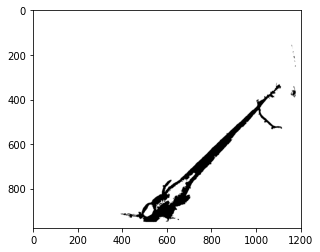

In [127]:
meniscus = get_meniscus_(hole, fishy.well_props.mask.cropped)
meniscus = meniscus.astype(float)
w_o_meniscus = hole.copy()
w_o_meniscus[(meniscus > 0)] = 0
plt.imshow(w_o_meniscus, 'binary')

11


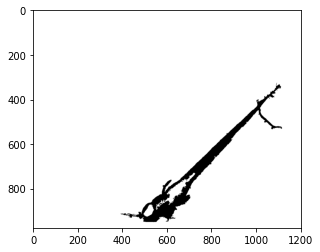

In [199]:
from skimage.measure import regionprops, regionprops_table
from skimage.color import label2rgb

labeled = label(w_o_meniscus)

props = regionprops_table(labeled, properties=('area','label'))
max_area = props['area'].max()
max_index = np.where(props['area'] == max_area)[0][0]
print(max_index)

r_props = regionprops(labeled)
labeled = label2rgb(labeled)
removed = remove_small_objects(w_o_meniscus.astype(bool), max_area-1).astype(int)


img = np.zeros_like(w_o_meniscus).copy()

plt.imshow(removed, 'binary')